# Game of Thrones End-To-End Notebook

This notebook contains an end-to-end workflow using a single csv file of Game of Thrones battle data.

In [1]:
import os
from neo4j_runway.utils.data import load_data_dictionary_from_yaml, load_local_files
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.discovery import Discovery
from neo4j_runway import GraphDataModeler
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.ingestion import PyIngest

## Read Data

In [2]:
data_dictionary = load_data_dictionary_from_yaml("data_dictionary.yaml")
data_dictionary

{'name': 'The name of the battle.',
 'year': 'The year the battle took place.',
 'battle_number': 'A unique ID for the battle.',
 'king': 'A king participating in the battle.',
 'outcome': 'Whether the battle was won or lost.',
 'family': 'A significant family in the battle.',
 'size': 'The size of the army.',
 'summer': 'Whether the battle took place during Summer.',
 'location': 'The location of the battle.',
 'region': 'The larger region a battle took place in.',
 'commander': 'The commander leading an army in the battle.',
 'attacking': 'Whether the army is attacking or not.'}

In [3]:
data_directory = "../../../data/got/"
file_name = "game_of_thrones_battles.csv"
data = load_local_files(data_directory=data_directory, 
                        general_description="This file contains data on game of thrones battles", 
                        data_dictionary=data_dictionary, 
                        use_cases=["What families have changed alliances?", "how have army sizes changed over time?", "Which families attack most often?"],
                        ignored_files=["got-battles.csv", "_.ipynb", "multi"])

In [4]:
data.tables[0].dataframe

,name,year,battle_number,king,outcome,family,size,summer,location,region,commander,attacking
0,Battle of the Golden Tooth,298,1,Joffrey/Tommen Baratheon,True,Lannister,15000.0,True,Golden Tooth,The Westerlands,Jaime Lannister,True
1,Battle at the Mummer's Ford,298,2,Joffrey/Tommen Baratheon,True,Lannister,NaN,True,Mummer's Ford,The Riverlands,Gregor Clegane,True
2,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,True,Lannister,15000.0,True,Riverrun,The Riverlands,Jaime Lannister,True
3,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,True,Lannister,15000.0,True,Riverrun,The Riverlands,Andros Brax,True
4,Battle of the Green Fork,298,4,Robb Stark,False,Stark,18000.0,True,Green Fork,The Riverlands,Roose Bolton,True
...,...,...,...,...,...,...,...,...,...,...,...,...
179,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Stannis Baratheon,False
180,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Jon Snow,False
181,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Donal Noye,False
182,Battle of Castle Black,300,28,Mance Rayder,True,Baratheon,1240.0,False,Castle Black,Beyond the Wall,Cotter Pyke,False


## Discovery

In [5]:
disc_llm = OpenAIDiscoveryLLM(model_name="gpt-4o-mini")
disc = Discovery(llm=disc_llm, data=data)

In [6]:
disc.run()

### Preliminary Analysis of Game of Thrones Battles Data

#### Overall Data Characteristics:
1. **Data Size**: The dataset contains 184 entries and 12 columns, indicating a moderate size for analysis.
2. **Data Types**: The features include a mix of categorical (object), numerical (int64, float64), and boolean data types. This diversity allows for various types of analyses.
3. **Missing Values**: Some columns have missing values:
   - `king`: 4 missing values
   - `outcome`: 6 missing values
   - `size`: 36 missing values
   - `summer`: 3 missing values
   - `location`: 2 missing values
   - `commander`: 10 missing values
   This indicates that data cleaning may be necessary before analysis.

#### Key Features:
1. **Year**: The battles occurred predominantly in the years 298 to 300, with a very narrow range. This suggests a limited time frame for the battles analyzed.
2. **Battle Number**: Each battle has a unique identifier, which is crucial for tracking individual battles.
3. **Size**: The army size varies significantly, with a mean of approximately 16,831 and a maximum of 100,000. The large standard deviation indicates a wide range of army sizes, which could be important for understanding battle dynamics.
4. **King**: The participation of kings shows a limited number of unique values (6), indicating that a few key figures are central to the battles.
5. **Outcome**: The outcome of battles is binary (won/lost), with a slight majority of battles won (101 out of 178). This could be useful for analyzing the effectiveness of different families or commanders.
6. **Family**: There are 21 unique families, with the Lannisters being the most frequently mentioned. This feature is critical for analyzing alliances and conflicts.
7. **Location and Region**: The battles took place in various locations and regions, with some locations being more common than others (e.g., Castle Black). This can help in understanding geographical strategies.
8. **Commander**: The dataset includes 81 unique commanders, with some commanding more frequently than others. This can provide insights into leadership effectiveness and strategies.

#### Use Case Insights:
1. **Families Changing Alliances**: The `family` and `king` features can be analyzed together to identify instances where families allied with different kings over time. This can be done by tracking the `king` associated with each `family` in different battles.
2. **Army Size Changes Over Time**: The `size` feature can be analyzed against the `year` to observe trends in army sizes. Given the missing values in `size`, it may be necessary to handle these appropriately (e.g., imputation or exclusion).
3. **Most Frequent Attackers**: The `family` feature can be aggregated to count the number of battles each family participated in, providing insights into which families were the most aggressive or involved in conflicts.

#### Conclusion:
The dataset provides a rich source of information for analyzing battles in the Game of Thrones universe. Key features such as `family`, `size`, `king`, and `outcome` will be instrumental in addressing the use cases outlined. However, attention must be paid to missing values and potential data cleaning before deeper analysis.

In [7]:
disc.to_markdown(file_dir="./outputs/")

## Data Modeling

In [8]:
gdm_llm = OpenAIDataModelingLLM(model_name="gpt-4o")
gdm = GraphDataModeler(llm=gdm_llm, discovery=disc)

In [9]:
gdm.create_initial_model(max_retries=3)

> Generating Nodes...
Attempts | 1  
Received Valid Nodes
Nodes
* (:Battle)   * (:King)
* (:Family)   * (:Commander) 

> Generating Data Model...
Attempts | 1  
Recieved Valid Data Model
Nodes
* (:Battle)   * (:King)
* (:Family)   * (:Commander) 

Relationships
* (:King)-[:PARTICIPATED_IN]->(:Battle)   
* (:Family)-[:INVOLVED_IN]->(:Battle)     
* (:Battle)-[:LED_BY]->(:Commander)       
* (:Family)-[:ALLIED_WITH]->(:King)       


DataModel(nodes=[Node(label='Battle', properties=[Property(name='name', type='str', column_mapping='name', alias=None, is_unique=True, part_of_key=False), Property(name='year', type='int', column_mapping='year', alias=None, is_unique=False, part_of_key=False), Property(name='battleNumber', type='int', column_mapping='battle_number', alias=None, is_unique=True, part_of_key=False), Property(name='outcome', type='str', column_mapping='outcome', alias=None, is_unique=False, part_of_key=False), Property(name='size', type='int', column_mapping='size', alias=None, is_unique=False, part_of_key=False), Property(name='summer', type='bool', column_mapping='summer', alias=None, is_unique=False, part_of_key=False), Property(name='location', type='str', column_mapping='location', alias=None, is_unique=False, part_of_key=False), Property(name='region', type='str', column_mapping='region', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='King', properties=[Property(na

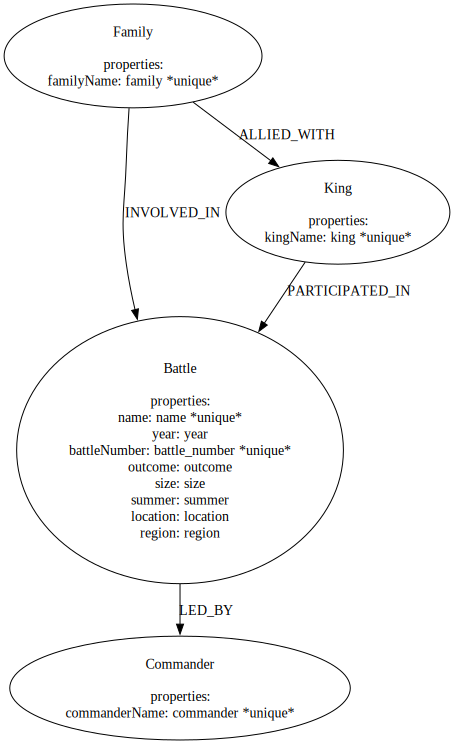

In [10]:
gdm.current_model.visualize()

In [11]:
corrections = "Create separate nodes for location and region. Add an attacking boolean property to LED_BY, PARTICPATED_IN and INVOLVED_IN. remove the node keys."
gdm.iterate_model(corrections=corrections, max_retries=3, allow_duplicate_properties=True)

> Generating Data Model...
Attempts | 1  
Recieved Valid Data Model
Nodes
* (:Battle)     * (:King)
* (:Family)     * (:Commander)
* (:Location)   * (:Region) 

Relationships
* (:King)-[:PARTICIPATED_IN]->(:Battle)   
* (:Family)-[:INVOLVED_IN]->(:Battle)     
* (:Battle)-[:LED_BY]->(:Commander)       
* (:Family)-[:ALLIED_WITH]->(:King)       
* (:Battle)-[:LOCATED_AT]->(:Location)    
* (:Location)-[:IN_REGION]->(:Region)     


DataModel(nodes=[Node(label='Battle', properties=[Property(name='name', type='str', column_mapping='name', alias=None, is_unique=True, part_of_key=False), Property(name='year', type='int', column_mapping='year', alias=None, is_unique=False, part_of_key=False), Property(name='battleNumber', type='int', column_mapping='battle_number', alias=None, is_unique=True, part_of_key=False), Property(name='outcome', type='str', column_mapping='outcome', alias=None, is_unique=False, part_of_key=False), Property(name='size', type='int', column_mapping='size', alias=None, is_unique=False, part_of_key=False), Property(name='summer', type='bool', column_mapping='summer', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='King', properties=[Property(name='kingName', type='str', column_mapping='king', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Family', properties=[Property(name='familyName', type='str', column_mapping='family', alias=

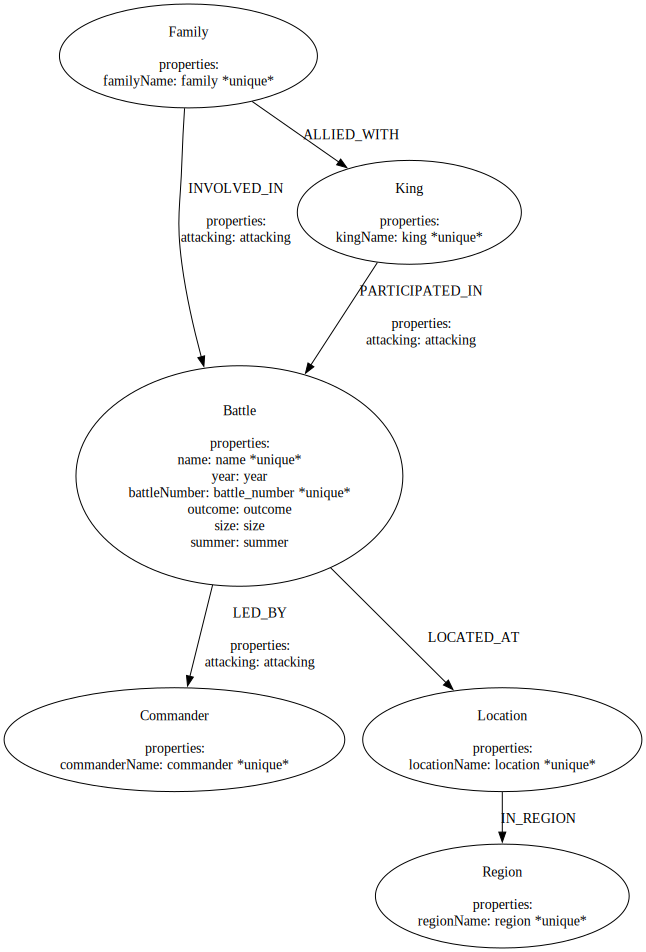

In [12]:
gdm.current_model.visualize()

## Code Generation

In [13]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, database="gameofthrones", username="neo4j", uri=os.environ.get("NEO4J_URI"), password=os.environ.get("NEO4J_PASSWORD"), source_name=file_name, file_directory=data_directory)

In [14]:
gen.generate_config_yaml(file_name="./outputs/config.yaml")

## Ingest

In [15]:
PyIngest(config=gen.generate_config_string())